# Laboratorium 4: Metody Bayesowskie

**Cel**: praktyczne zastosowanie metod bayesowskich do klasyfikacji i regresji oraz implementacja online'owej regresji liniowej Bayesa.

> **Wskazówki dot. środowiska**
> - Używamy `numpy`, `pandas`, `scikit-learn`, `matplotlib`

In [1]:
import os, sys, math, json, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, classification_report, brier_score_loss, mean_squared_error, r2_score
)
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import BayesianRidge, Ridge, LinearRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn import datasets

warnings.filterwarnings("ignore")
np.random.seed(42)

## Zadanie 1: Gaussowski Naiwny Klasyfikator Bayesa

- Zaimplementuj **Gaussian Naive Bayes**. Predykcję klasy wykonuj poprzez maksymalizację posterioru
- Przetestuj klasyfikator dla danych: Breast Cancer Wisconsin (30 cech, `sklearn.datasets.load_breast_cancer`)
  - Zawiera 569 próbek komórek pobranych z biopsji sutka. Każda próbka została oznaczona jako: M (malignant) - złośliwy nowotwór, B (benign) - łagodny nowotwór.
  - Każda próbka jest opisana 30 cechami numerycznymi, wyliczonymi z obrazu mikroskopowego jądra komórkowego.
-  Utwórz pipeline: `PowerTransformer(yeo-johnson)` → opcjonalnie `PCA` → Twój `GaussianNBFromScratch`
   - `PowerTransformer` umożliwia stabilizację wariancji i przybliżenie rozkładu danych do normalnego (Gaussa)
   - Metoda Yeo–Johnson jest podobna do transformacji Box–Coxa, ale obsługuje również wartości ujemne i zero, co czyni ją bardziej uniwersalną.
- Wyznacz **metryki:** `accuracy`, `precision`, `recall`, `f1`, macierz pomyłek, **krzywe kalibracji** oraz **Brier score**
  - **Krzywa kalibracji** to wykres, który pokazuje zgodność między przewidywanym prawdopodobieństwem a rzeczywistą częstością zdarzenia
  - Idealny model: punkty leżą na przekątnej (y = x) → oznacza idealną kalibrację
  - Jeśli punkty są poniżej przekątnej → model zbyt pewny siebie (przecenia swoje prognozy)
  - Jeśli powyżej → model zbyt ostrożny (niedoszacowuje prawdopodobieństw)
  - **Brier score** to miara błędu prognozy probabilistycznej, która ocenia, jak bliskie są przewidywane prawdopodobieństwa wartościom rzeczywistym (0 lub 1).
  - Zakres: 0 → idealna kalibracja, 1 → najgorsza możliwa.
- Porównaj z `sklearn.naive_bayes.GaussianNB` i skomentuj różnice

Student: acc=0.942004, f1=0.954608, brier=0.040748
Sklearn: acc=0.942004, f1=0.954608, brier=0.040748
Różnica w prawdopodobieństwach: max=0.0000000691


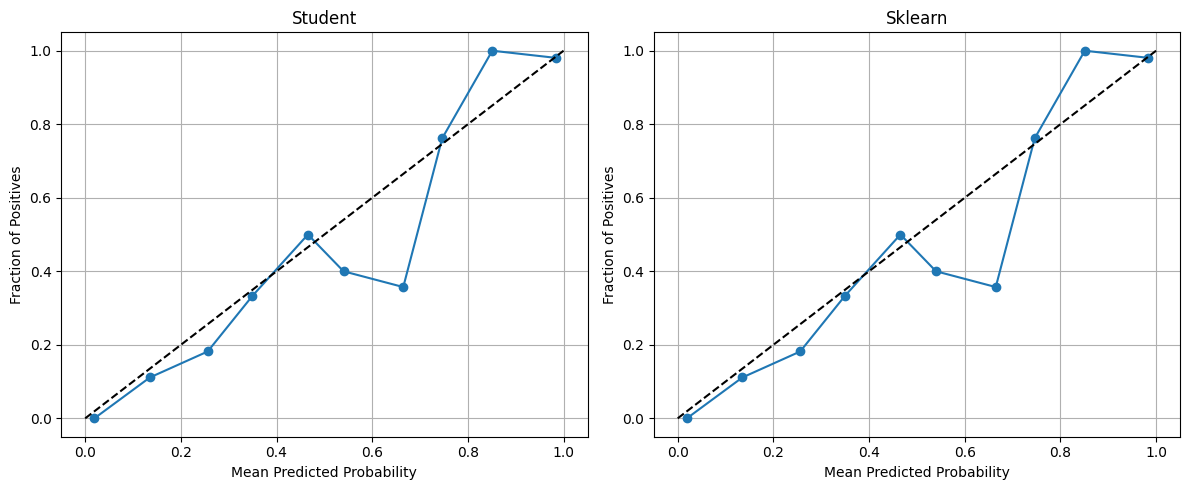

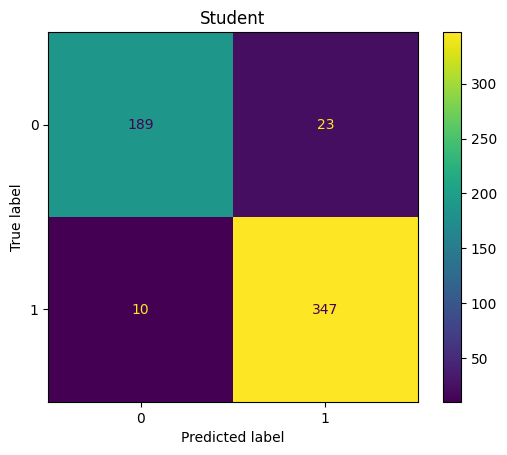

In [2]:
class GaussianNBFromScratch:
    def __init__(self, var_smoothing=1e-9):
        self.var_smoothing = var_smoothing
        self.classes_ = None
        self.class_prior_ = None
        self.theta_ = None  # średnie [n_classes, n_features]
        self.sigma_ = None  # wariancje [n_classes, n_features]

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        self.classes_, y_idx = np.unique(y, return_inverse=True)
        n_classes = len(self.classes_)
        n_features = X.shape[1]
        
        self.theta_ = np.zeros((n_classes, n_features))
        self.sigma_ = np.zeros((n_classes, n_features))
        self.class_prior_ = np.zeros(n_classes)
        
        for k in range(n_classes):
            mask = y_idx == k
            X_k = X[mask]
            self.theta_[k] = np.mean(X_k, axis=0)
            self.sigma_[k] = np.var(X_k, axis=0) + self.var_smoothing
            self.class_prior_[k] = np.sum(mask) / len(y)
        
        return self

    def _log_gaussian_density(self, X):
        X = np.asarray(X, dtype=float)
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        log_probs = np.zeros((n_samples, n_classes))
        
        for k in range(n_classes):
            diff = X - self.theta_[k]
            log_var = np.log(2 * np.pi * self.sigma_[k])
            squared_diff = diff ** 2 / self.sigma_[k]
            log_probs[:, k] = -0.5 * np.sum(log_var + squared_diff, axis=1)
        
        return log_probs

    def predict_proba(self, X):
        log_likelihood = self._log_gaussian_density(X)
        log_prior = np.log(self.class_prior_)
        log_posterior = log_likelihood + log_prior
        
        log_posterior -= np.max(log_posterior, axis=1, keepdims=True)
        posterior = np.exp(log_posterior)
        posterior /= np.sum(posterior, axis=1, keepdims=True)
        
        return posterior

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]


# ==== Załaduj dane i zbuduj pipeline ====
from sklearn.decomposition import PCA

X, y = datasets.load_breast_cancer(return_X_y=True, as_frame=True)
num_features = X.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", PowerTransformer(method="yeo-johnson"), num_features),
    ],
    remainder="drop"
)

pipeline_student = Pipeline([
    ("prep", preprocess),
    ("pca", PCA(n_components=0.95, svd_solver="full")),
    ("gnb", GaussianNBFromScratch(var_smoothing=1e-9))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pipeline_sklearn = Pipeline([("prep", preprocess), ("pca", PCA(n_components=0.95, svd_solver="full")), ("gnb", GaussianNB(var_smoothing=1e-9))])

y_true_s, y_pred_s, y_proba_s = [], [], []
y_true_sk, y_pred_sk, y_proba_sk = [], [], []

for train_idx, val_idx in skf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    pipeline_student.fit(X_train, y_train)
    pipeline_sklearn.fit(X_train, y_train)
    
    y_pred_s.extend(pipeline_student.predict(X_val))
    y_proba_s.extend(pipeline_student.predict_proba(X_val)[:, 1])
    y_pred_sk.extend(pipeline_sklearn.predict(X_val))
    y_proba_sk.extend(pipeline_sklearn.predict_proba(X_val)[:, 1])
    y_true_s.extend(y_val)
    y_true_sk.extend(y_val)

y_true_s, y_pred_s, y_proba_s = np.array(y_true_s), np.array(y_pred_s), np.array(y_proba_s)
y_true_sk, y_pred_sk, y_proba_sk = np.array(y_true_sk), np.array(y_pred_sk), np.array(y_proba_sk)

print("Student:", f"acc={accuracy_score(y_true_s, y_pred_s):.6f}, f1={f1_score(y_true_s, y_pred_s):.6f}, brier={brier_score_loss(y_true_s, y_proba_s):.6f}")
print("Sklearn:", f"acc={accuracy_score(y_true_sk, y_pred_sk):.6f}, f1={f1_score(y_true_sk, y_pred_sk):.6f}, brier={brier_score_loss(y_true_sk, y_proba_sk):.6f}")
print(f"Różnica w prawdopodobieństwach: max={np.max(np.abs(y_proba_s - y_proba_sk)):.10f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, y_true, y_proba, title in zip(axes, [y_true_s, y_true_sk], [y_proba_s, y_proba_sk], ['Student', 'Sklearn']):
    frac_pos, mean_pred = calibration_curve(y_true, y_proba, n_bins=10)
    ax.plot(mean_pred, frac_pos, 'o-')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives')
    ax.set_title(title)
    ax.grid(True)
plt.tight_layout()
plt.show()

ConfusionMatrixDisplay.from_predictions(y_true_s, y_pred_s)
plt.title('Student')
plt.show()

## Zadanie 2: Multinomial/Complement Naive Bayes

- Zbiór danych **20 Newsgroups**
  - Zawiera około 18000 wiadomości tekstowych z 20 różnych grup dyskusyjnych (newsgroups) z lat 90
  - Każdy dokument reprezentuje post z forum internetowego, przypisany do jednej z 20 kategorii tematycznych
- Użyj `TfidfVectorizer` + `MultinomialNB` (rozkład wielomianowy) do klasyfikacji wiadomości tekstowych (20NG)
  - `ngram_range=(1, 2)`: unigramy oraz bigramy
  - `min_df=2`
  - `max_df=0.9`
  - `stop_words="english"`
  - `alpha`: additive (Laplace/Lidstone) smoothing parameter (set alpha=0 and force_alpha=True, for no smoothing).`
- Porównaj z `ComplementNB` (często lepszy przy niezbalansowanych danych)
  - `ComplementNB` zamiast obliczać prawdopodobieństwa dla klasy bezpośrednio, używa danych komplementarnych, tzn. bierze pod uwagę wszystkie pozostałe klasy oprócz danej
  - W ten sposób poprawia stabilność i dokładność klasyfikacji , szczególnie dla niezrównoważonych danych.
- **Metryki i analiza:** accuracy, macro-F1, raport per-klasa, top-słowa dla wybranych klas, wpływ `alpha` (Laplace/Lidstone smoothing)


In [3]:
from sklearn.datasets import fetch_20newsgroups

train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42)
X_train, y_train = train.data, train.target
X_test, y_test = test.data, test.target

pipeline_mnb = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.9, stop_words='english')),
    ('mnb', MultinomialNB(alpha=1.0))
])

pipeline_cnb = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.9, stop_words='english')),
    ('cnb', ComplementNB(alpha=1.0))
])

pipeline_mnb.fit(X_train, y_train)
pipeline_cnb.fit(X_train, y_train)

y_pred_mnb = pipeline_mnb.predict(X_test)
y_pred_cnb = pipeline_cnb.predict(X_test)

print("MultinomialNB:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mnb):.4f}")
print(f"Macro-F1: {f1_score(y_test, y_pred_mnb, average='macro'):.4f}")
print("\nComplementNB:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_cnb):.4f}")
print(f"Macro-F1: {f1_score(y_test, y_pred_cnb, average='macro'):.4f}")

print("\n=== Classification Report (MultinomialNB) ===")
print(classification_report(y_test, y_pred_mnb, target_names=train.target_names))

print("\n=== Classification Report (ComplementNB) ===")
print(classification_report(y_test, y_pred_cnb, target_names=train.target_names))

vectorizer = pipeline_mnb.named_steps['tfidf']
mnb_model = pipeline_mnb.named_steps['mnb']
feature_names = vectorizer.get_feature_names_out()

for class_idx in [0, 1, 2]:
    class_name = train.target_names[class_idx]
    log_probs = mnb_model.feature_log_prob_[class_idx]
    top_indices = np.argsort(log_probs)[-10:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    print(f"\nTop 10 słów dla klasy '{class_name}':")
    print(top_words)

alphas = [0.1, 0.5, 1.0, 2.0, 5.0]
print("\n=== Wpływ alpha na MultinomialNB ===")
for alpha in alphas:
    model = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.9, stop_words='english')),
        ('mnb', MultinomialNB(alpha=alpha))
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"alpha={alpha}: acc={accuracy_score(y_test, y_pred):.4f}, f1={f1_score(y_test, y_pred, average='macro'):.4f}")

MultinomialNB:
Accuracy: 0.8093
Macro-F1: 0.7966

ComplementNB:
Accuracy: 0.8320
Macro-F1: 0.8236

=== Classification Report (MultinomialNB) ===
                          precision    recall  f1-score   support

             alt.atheism       0.80      0.74      0.77       319
           comp.graphics       0.75      0.73      0.74       389
 comp.os.ms-windows.misc       0.80      0.69      0.74       394
comp.sys.ibm.pc.hardware       0.64      0.76      0.70       392
   comp.sys.mac.hardware       0.85      0.77      0.81       385
          comp.windows.x       0.84      0.78      0.81       395
            misc.forsale       0.79      0.82      0.81       390
               rec.autos       0.87      0.88      0.87       396
         rec.motorcycles       0.91      0.93      0.92       398
      rec.sport.baseball       0.86      0.91      0.88       397
        rec.sport.hockey       0.83      0.97      0.90       399
               sci.crypt       0.80      0.94      0.87       

## Zadanie 3: Bayesian Ridge Regression (szacunek niepewności)

Użyj `BayesianRidge` na problemie regresyjnym (`sklearn.datasets.load_diabetes`, a w dalszej kolejności wybrany przez siebie zbiór danych np. Kaggle Bike Sharing Demand)

1. Zbuduj pipeline z odpowiednim przetwarzaniem (one-hot dla kategorii, skalowanie dla liczb)
2. Porównaj `LinearRegression`, `Ridge`, `BayesianRidge` pod względem RMSE i R².
  - `LinearRegression`: zwykła regresja najmniejszych kwadratów (bez regularyzacji)
  - `Ridge`: OLS + regularyzacja L2 na wagach
  - `BayesianRidge`: Wersja bayesowska: priory na wagach i szum; automatyczna regularyzacja.
3. Dla `BayesianRidge` narysuj 95% przedziały predykcyjne (`predict(return_std=True)`)
4. Oblicz przybliżony **Negative Log Predictive Density (NLPD)** zakładając normalność błędu.
  - Miara jakości modelu probabilistycznego: ocenia jak dobrze model przewiduje rozkład prawdopodobieństwa wyników, a nie tylko średnią prognozę
  - Ocenia cały rozkład predykcyjny (średnią i wariancję), nie tylko trafność predykcji
  - Jeśli model dobrze dopasowuje zarówno wartość oczekiwaną, jak i niepewność, NLPD będzie niskie
  - Wysoki NLPD oznacza, że model: ma zbyt wąski rozkład (zbyt pewny siebie), albo przewiduje zbyt szerokie niepewności (za mało pewny), lub nie trafia w środek rozkładu wyników
  - Skomentuj uzyskane wyniki


LR: RMSE=53.1202, R²=0.4773
Ridge: RMSE=53.1035, R²=0.4776
BayesRidge: RMSE=53.0561, R²=0.4785


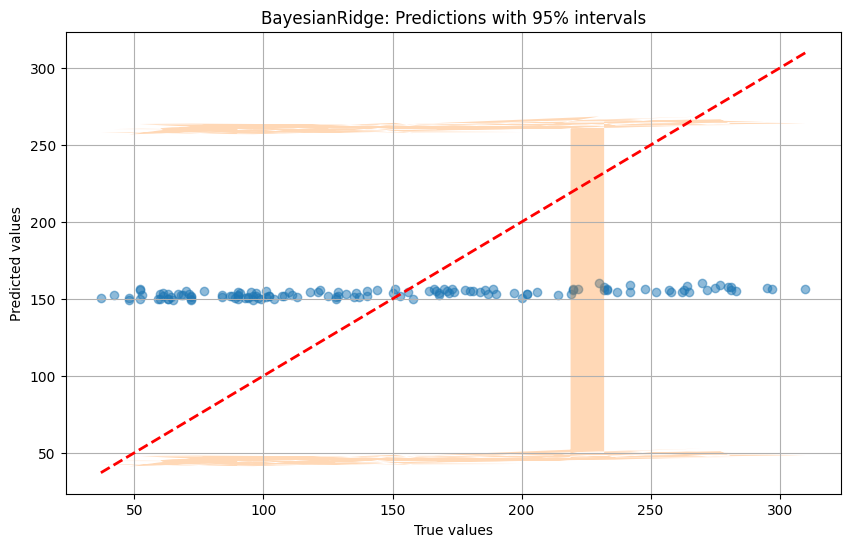


NLPD (Negative Log Predictive Density): 5.7818


In [4]:
X, y = datasets.load_diabetes(return_X_y=True, as_frame=True)

num_cols = X.columns.tolist()
pre = ColumnTransformer([("num", StandardScaler(), num_cols)], remainder="drop")

models = {
    "LR": Pipeline([("pre", pre), ("m", LinearRegression())]),
    "Ridge": Pipeline([("pre", pre), ("m", Ridge(alpha=1.0))]),
    "BayesRidge": Pipeline([("pre", pre), ("m", BayesianRidge(compute_score=True))]),
}

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    results[name] = {'RMSE': rmse, 'R²': r2}
    print(f"{name}: RMSE={rmse:.4f}, R²={r2:.4f}")

bayes_model = models['BayesRidge']
y_pred_bayes, y_std_bayes = bayes_model.named_steps['m'].predict(X_val, return_std=True)

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_bayes, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.fill_between(y_val, y_pred_bayes - 1.96*y_std_bayes, y_pred_bayes + 1.96*y_std_bayes, alpha=0.3)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('BayesianRidge: Predictions with 95% intervals')
plt.grid(True)
plt.show()

nlpd = -np.mean(-0.5 * np.log(2 * np.pi * y_std_bayes**2) - 0.5 * ((y_val - y_pred_bayes) / y_std_bayes)**2)
print(f"\nNLPD (Negative Log Predictive Density): {nlpd:.4f}")

## Zadanie 4: Regresja liniowa Bayesa *online* (implementacja)

- Zaimplementuj Liniową Regresję Bayesowską w wersji online korzystając z klasy pomocniczej. Zastosuj wzory ze slajdów wykładu.
  - Posterior:
    $$p(w_{i+1}|w_i,x_i,t_i)=N(w_{i+1}|m_{i+1},S_{i+1})$$
    $$S_{i+1} = (S_i^{-1} + β x_i x_i^T)^{-1}$$
    $$m_{i+1} = S_{i+1}(S_i^{-1} m_i + β t_i x_i)$$   
  - Predykcja:
    $$μ_i = w_i^T x_i$$
    $$σ_i^2 = β^{-1} + x_i^T S_i x_i$$
- Następnie wygeneruj dane $t = -0.2 + 0.6 x + ε$, $ε \sim N(0, 0.2^2)$ i
zwizualizuj kolejne aktualizacje (kontury prior/posterior w przestrzeni `w1,w2` oraz rozrzut punktów i przedziały predykcyjne)
- **Podpowiedzi:** zob. wzory (76)–(81) i sekwencję aktualizacji na slajdach „Online belief updating”

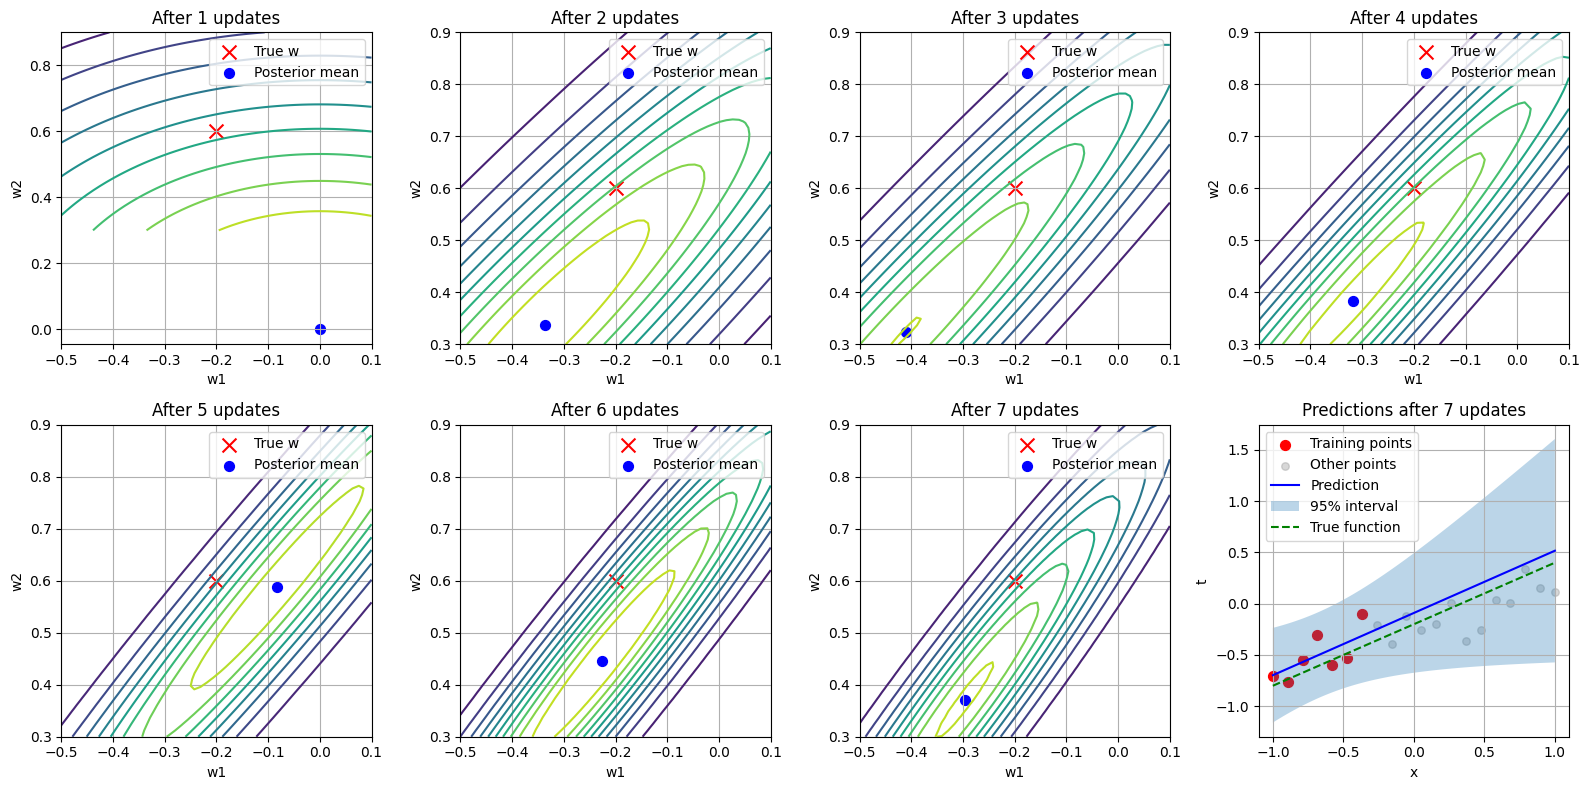

In [5]:
class BayesianLinearRegressionOnline:
    def __init__(self, n_features, alpha=2.0, beta=25.0):
        self.n_features = n_features
        self.alpha = alpha
        self.beta = beta
        self.m = np.zeros(n_features)  # mean
        self.S = np.eye(n_features) / alpha  # covariance (S0 = α^{-1} I)

    def update(self, x, t):
        x = np.asarray(x).reshape(-1,1)
        S_inv = np.linalg.inv(self.S)
        S_new = np.linalg.inv(S_inv + self.beta * (x @ x.T))
        m_new = S_new @ (S_inv @ self.m + self.beta * t * x.flatten())
        self.S = S_new
        self.m = m_new.reshape(-1)

    def predict(self, x):
        x = np.asarray(x).reshape(-1,1)
        mean = float(self.m @ x.flatten())
        var = float(1.0/self.beta + (x.T @ self.S @ x).item())
        return mean, var

# ==== Dane syntetyczne ====
n = 20
xs = np.linspace(-1, 1, n)
true_w = np.array([-0.2, 0.6])  # [w1, w2]
noise_std = 0.2
ts = true_w[0] + true_w[1]*xs + np.random.normal(0, noise_std, size=n)

model = BayesianLinearRegressionOnline(n_features=2, alpha=2.0, beta=25.0)

from scipy.stats import multivariate_normal

X_data = np.column_stack([np.ones(len(xs)), xs])

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(7):
    ax = axes[i]
    x_i = X_data[i]
    t_i = ts[i]
    
    w1_range = np.linspace(-0.5, 0.1, 50)
    w2_range = np.linspace(0.3, 0.9, 50)
    W1, W2 = np.meshgrid(w1_range, w2_range)
    
    pos = np.dstack((W1, W2))
    rv = multivariate_normal(model.m, model.S)
    Z = rv.pdf(pos)
    
    ax.contour(W1, W2, Z, levels=10)
    ax.scatter(true_w[0], true_w[1], c='r', marker='x', s=100, label='True w')
    ax.scatter(model.m[0], model.m[1], c='b', marker='o', s=50, label='Posterior mean')
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_title(f'After {i+1} updates')
    ax.legend()
    ax.grid(True)
    
    model.update(x_i, t_i)

ax = axes[7]
x_plot = np.linspace(-1, 1, 100)
X_plot = np.column_stack([np.ones(len(x_plot)), x_plot])
y_pred = np.array([model.predict(x)[0] for x in X_plot])
y_std = np.array([np.sqrt(model.predict(x)[1]) for x in X_plot])

ax.scatter(xs[:7], ts[:7], c='r', label='Training points', s=50)
ax.scatter(xs[7:], ts[7:], c='gray', alpha=0.3, label='Other points', s=30)
ax.plot(x_plot, y_pred, 'b-', label='Prediction')
ax.fill_between(x_plot, y_pred - 1.96*y_std, y_pred + 1.96*y_std, alpha=0.3, label='95% interval')
ax.plot(x_plot, true_w[0] + true_w[1]*x_plot, 'g--', label='True function')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Predictions after 7 updates')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

## Zadanie 5: Decyzja z kosztami i kalibracja (Adult Income) - dodatkowe

**Cel:** zbudować klasyfikator dochodu (>50K vs. ≤50K), skalibrować jego prawdopodobieństwa oraz wybrać próg decyzji $\tau$, który minimalizuje oczekiwaną stratę dla zadanej macierzy kosztów.

**Teoria:**
- Decyzja minimalizująca prawdopodobieństwo błędu: wybierz klasę o większym $P(C_k | x)$
- Koszty/straty: dla macierzy $L$ szukamy progu $\tau$, który minimalizuje $\mathbb E[L]$
- Kalibracja (np. izotoniczna) poprawia zgodność estymowanych $P(C_k | x)$ z częstościami empirycznymi

**Wykorzystaj**:
- **GaussianNB** + **OneHotEncoder/StandardScaler** (pipeline), **CalibratedClassifierCV** (`method="isotonic"`),
- Wykres **calibration curve**, **Brier score** i przeszukiwanie $\tau$ pod zadaną macierz kosztów

**Polecenia**:
1. Wczytaj zbiór danych *Adult Income* z OpenML
3. **Przygotowanie cech** (`ColumnTransformer`): `OneHotEncoder(handle_unknown="ignore")` dla kategorycznych, `StandardScaler` dla liczbowych. Densyfikacja połączonej macierzy.  
4. **Model bazowy:** `GaussianNB` w pipeline + **kalibracja izotoniczna** (`CalibratedClassifierCV`)  
   - Dzielimy dane: **70% tren**, **30% walidacja** (stratyfikacja)  
   - Używamy `CalibratedClassifierCV` (izotoniczna) do poprawy kalibracji $P(C_{k}=1| x)$
   - Obliczamy bazowe metryki przy progu $\tau=0.5$: accuracy, precision, recall, F1, **Brier score**, oraz macierz pomyłek
5. **Ewaluacja** na zbiorze walidacyjnym: accuracy, F1, **Brier**, macierz pomyłek i **krzywa kalibracji**  
6. **Decyzja uwarunkowana kosztem:** zdefiniuj macierz strat $L$ i znajdź optymalny próg $\tau^{⋆}$ minimalizujący $\mathbb E[L]$  
   - Zdefiniuj **macierz strat** $L$ dla problemu binarnego:  
$$
L =
\begin{bmatrix}
0 & c_{01} \\
c_{10} & 0
\end{bmatrix},
$$
gdzie $c_{01}$ to koszt **fałszywego alarmu (FP)**, a $c_{10}$ to koszt **przeoczenia pozytywnej klasy (FN)**.
   - Dla danego progu $\tau$ i predykcji szacujemy średni koszt decyzji
   - Wykonaj obliczenia z **kosztem FN pięciokrotnie większym** od FP: $c_{10}=5, c_{01}=1$, wyznaczając optymalne $\tau^{⋆}$
7. Przedstaw raport końcowy dla $\tau^{⋆}$: metryki i macierz pomyłek  
8. Powtórz eksperyment z innymi kosztami $L$
9. Przedstaw podsumowanie i wnioski. Co dzieje się z optymalnym progiem $\tau^{⋆}$ gdy zmieniają się proporcje między $c_{10}$, a $c_{01}$?